### Package Loading and Object creating

In [1]:
import anndata
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.5 anndata==0.10.2 umap==0.5.4 numpy==1.26.1 scipy==1.11.3 pandas==2.1.1 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.10


In [4]:
results_file = "write/pbmc3k.h5ad" # the file that will store the analysis resultss

In [5]:
adata = sc.read_10x_mtx(
    'filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/filtered_gene_bc_matrices-hg19-matrix.h5ad


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### Preprocessing 

normalizing counts per cell
    finished (0:00:00)


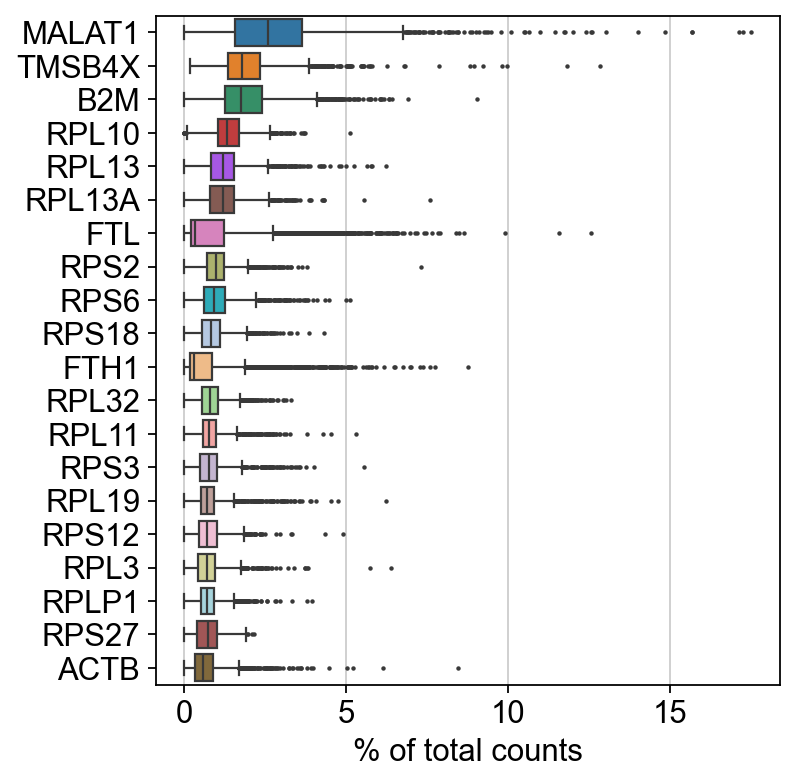

In [8]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering [pp.filter_cells documentation](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.filter_cells.html)

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


The larger of ratio of mitochondrial genes versus nuclear genes, the higher of the likelihood that the data is in poor condition.

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [11]:
adata_obs_df = pd.DataFrame(adata.obs)
adata_obs_df.reset_index(inplace=True)
melted_adata_obs_df = pd.melt(adata_obs_df, id_vars=['index'], value_vars=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                              var_name='variable', value_name='count')
melted_adata_obs_df.head(5)

,index,variable,count
0,AAACATACAACCAC-1,n_genes_by_counts,779.0
1,AAACATTGAGCTAC-1,n_genes_by_counts,1352.0
2,AAACATTGATCAGC-1,n_genes_by_counts,1129.0
3,AAACCGTGCTTCCG-1,n_genes_by_counts,960.0
4,AAACCGTGTATGCG-1,n_genes_by_counts,521.0


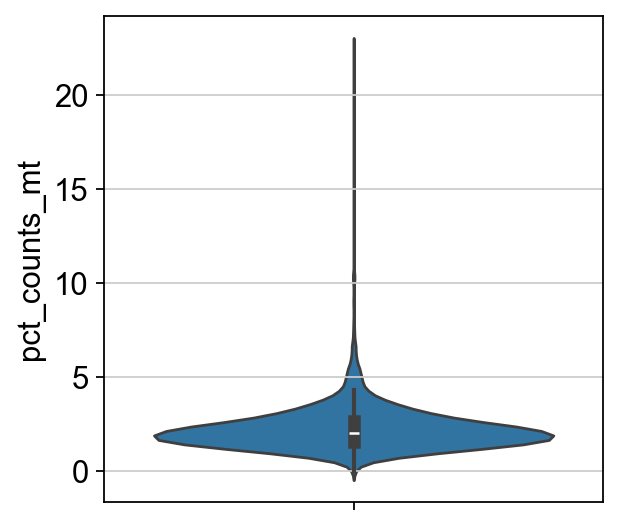

In [12]:
#sns.violinplot(x="variable", y='count', data = melted_adata_obs_df)
sns.violinplot(y='pct_counts_mt', data = adata_obs_df)
plt.show()

In [13]:
pd.DataFrame(adata.obs).head(5)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490


In [14]:
# sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
# problem here

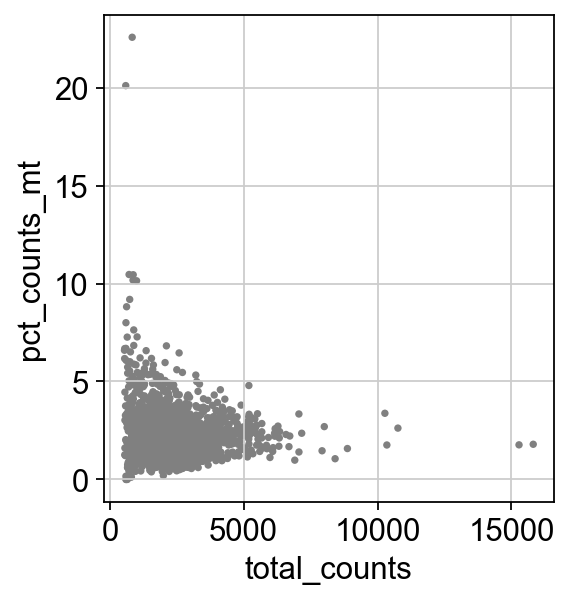

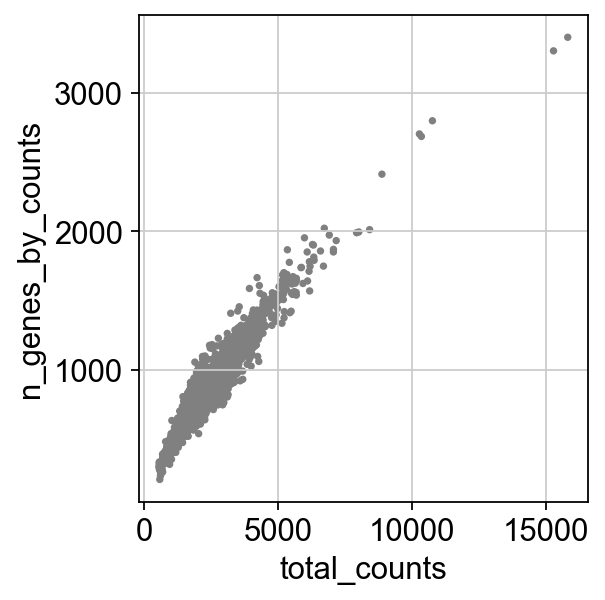

In [15]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

pct = Cumulative percentage of counts

data trimming: Remove cells that have too many mitochondrial genes expressed or too many total counts

In [16]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell, so that counts become comparable among cells.

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
sc.pp.log1p(adata)

In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) # this function only accepts the count data in log form, expcept when flavor='seurat_v3'

extracting highly variable genes


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


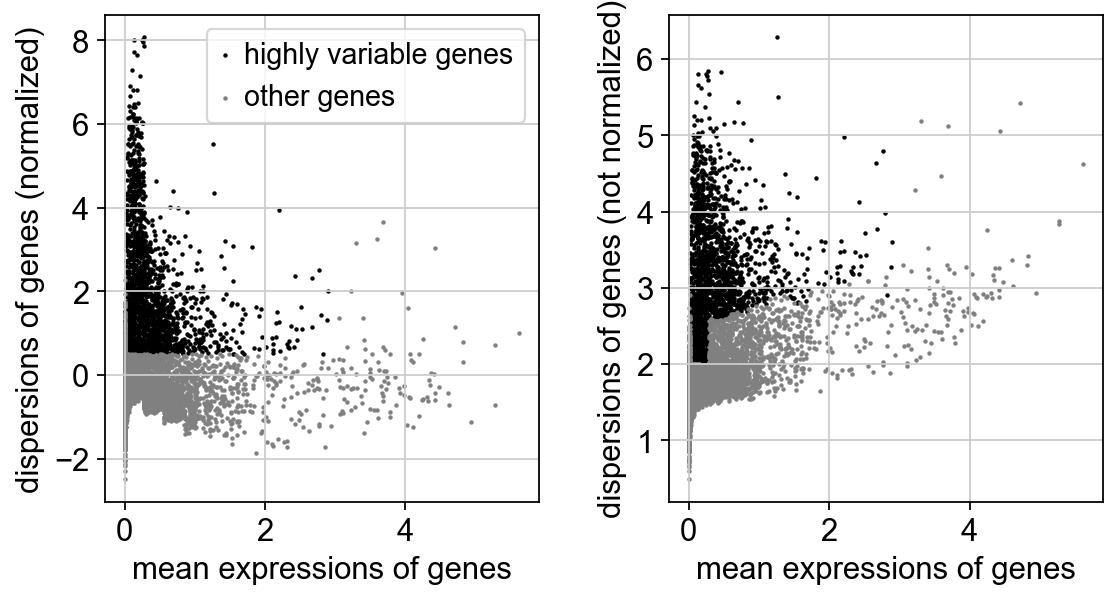

In [20]:
sc.pl.highly_variable_genes(adata)
# how do the software treat the dispersion, will it shrink the gene-wise dispersion as Deseq2 does?

In [21]:
adata.raw = adata

In [22]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [23]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:619: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if keys[0] in adata.obs_keys() and is_categorical_dtype(adata.obs[keys[0]]):


    finished (0:00:06)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [24]:
sc.pp.scale(adata, max_value=10)

### Principal Component Analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


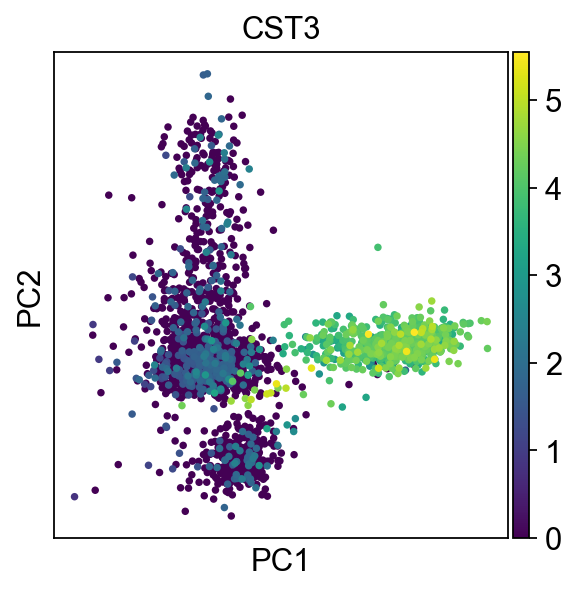

In [25]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

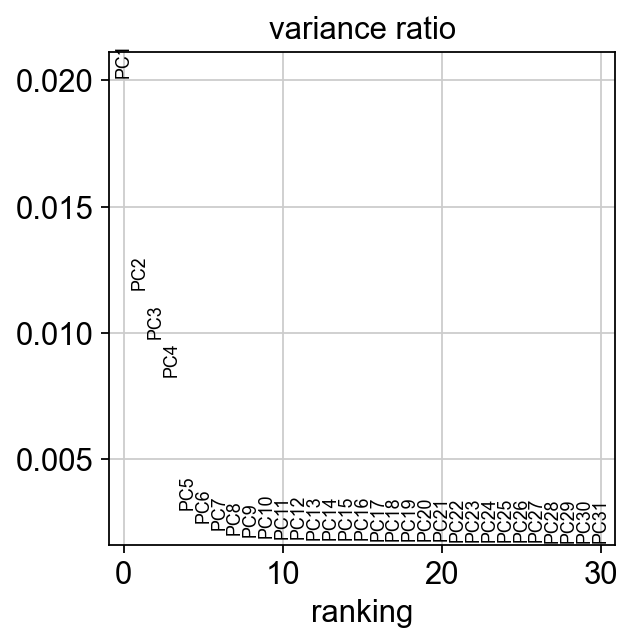

In [26]:
sc.pl.pca_variance_ratio(adata, log=False)
# is 0.020 of PC1 a good capature of PCA?, what is the empirical standard to define a good pratice of  PCA

In [27]:
adata.write(results_file)

In [28]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Computing the neighborhood graph

In [29]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


### Embedding the neighborhood graph (UMAP)

In [30]:
sc.tl.louvain(adata) #run this before running sc.tl.paga

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


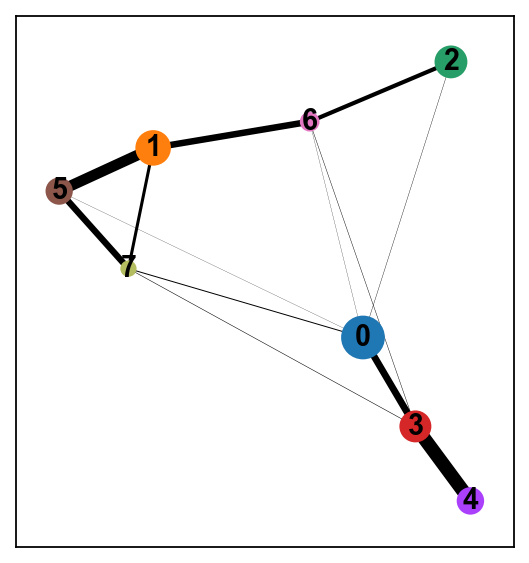

In [31]:
sc.tl.paga(adata) # computational function 
sc.pl.paga(adata, plot=True) #coarse-grained graph #plot function

[sc.pl.paga](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.paga.html)

PAGA(Partition-based graph abstraction), in which edge weights represent confidence in the presence of connections. 

In [32]:
sc.tl.umap(adata, init_pos='paga')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


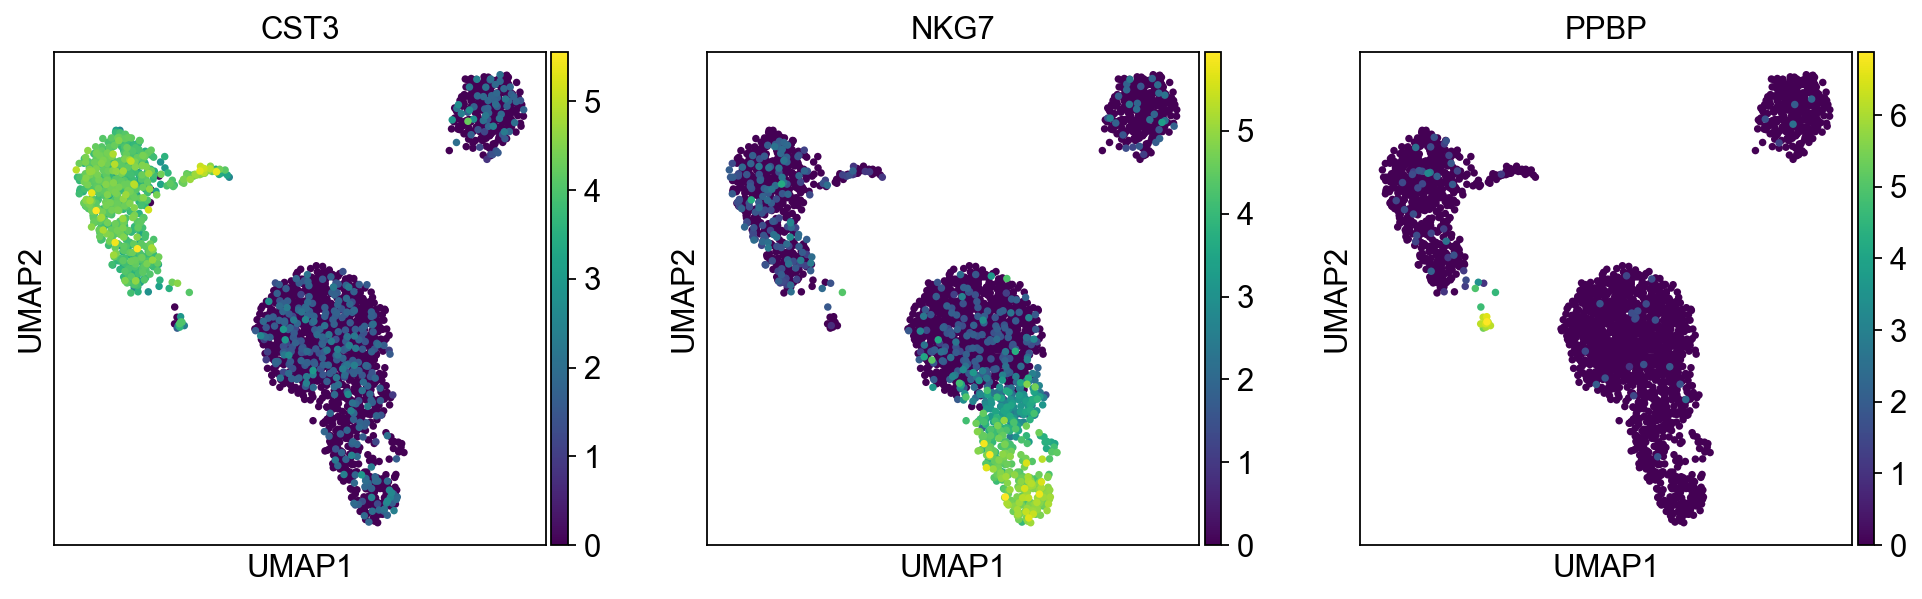

In [33]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


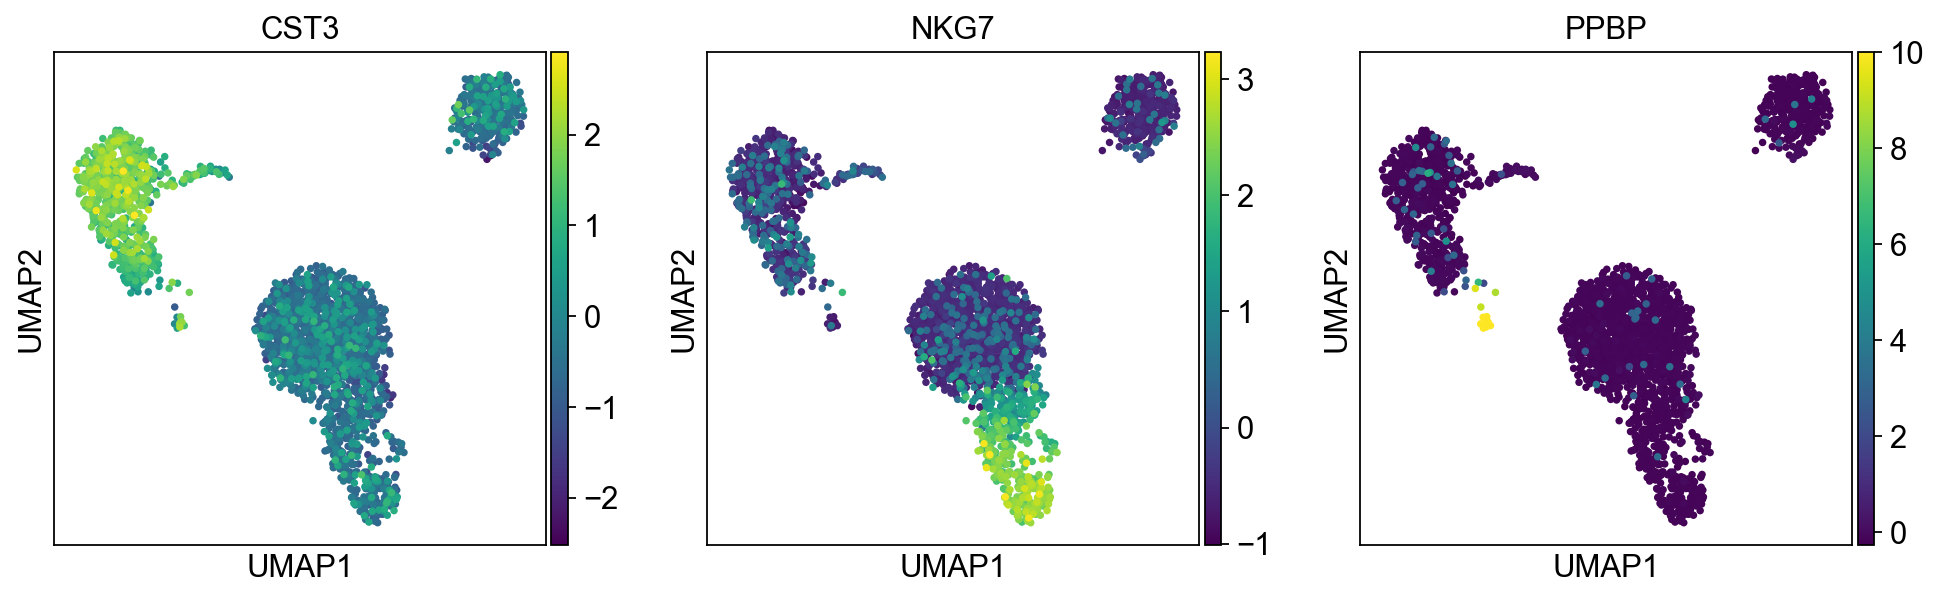

In [34]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [35]:
adata.write(results_file)

What is the difference between PCA and UMAP? 
- PCA a linear transformation that capatures the most variance of the data, captures global structure, UMAP nonlinear approach that captures the local and global structures 
- How to interpret the graphs generated using the same data 

### Clustering the neighborhood graph

In [36]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: i

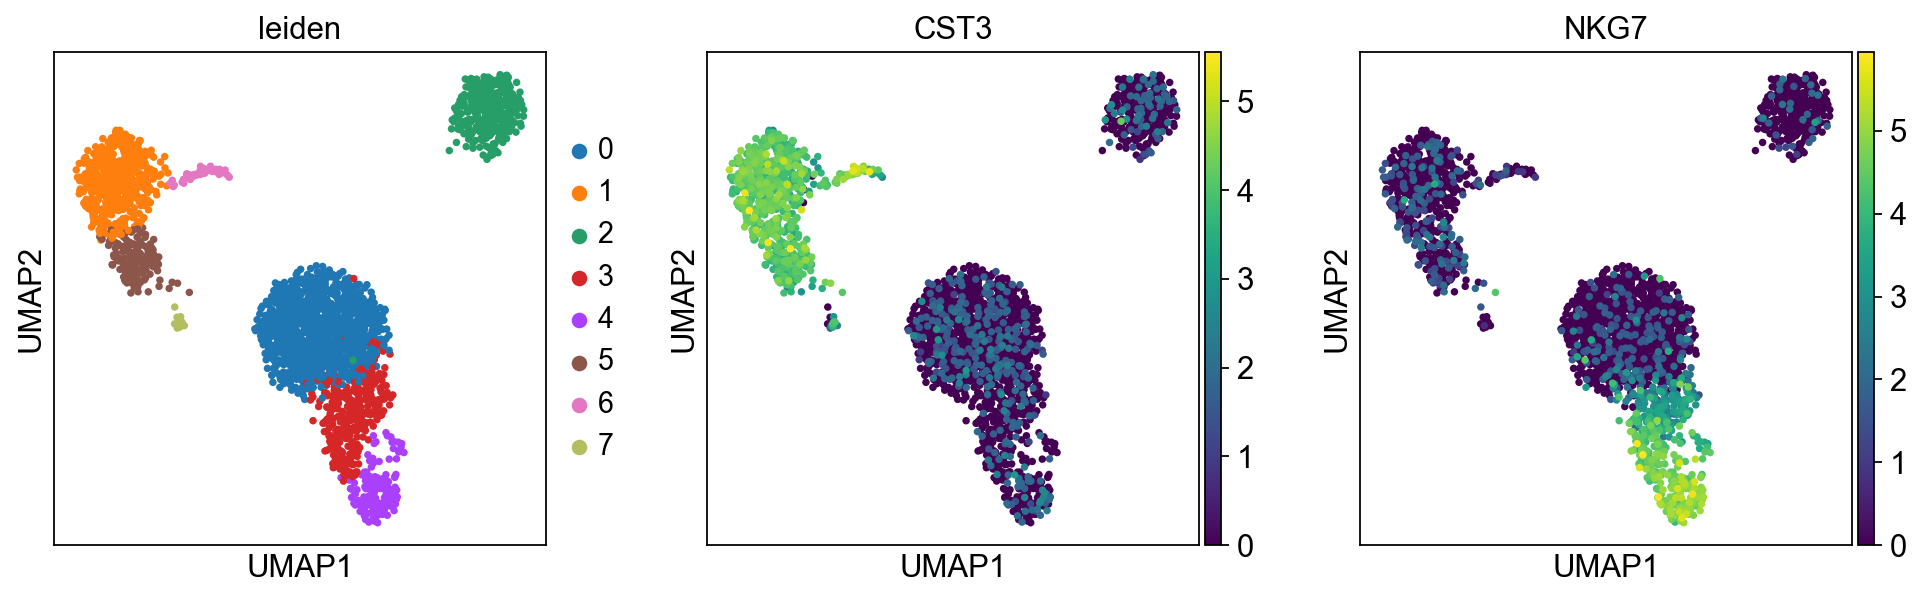

In [37]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [38]:
adata.write(results_file)

### Finding marker genes

#### t-test 

In [39]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'louvain', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'paga', 'louvain_sizes', 'louvain_colors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [40]:
adata.obsp['connectivities'].toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [41]:
(adata.uns)['leiden']

{'params': {'resolution': 1, 'random_state': 0, 'n_iterations': -1}}

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


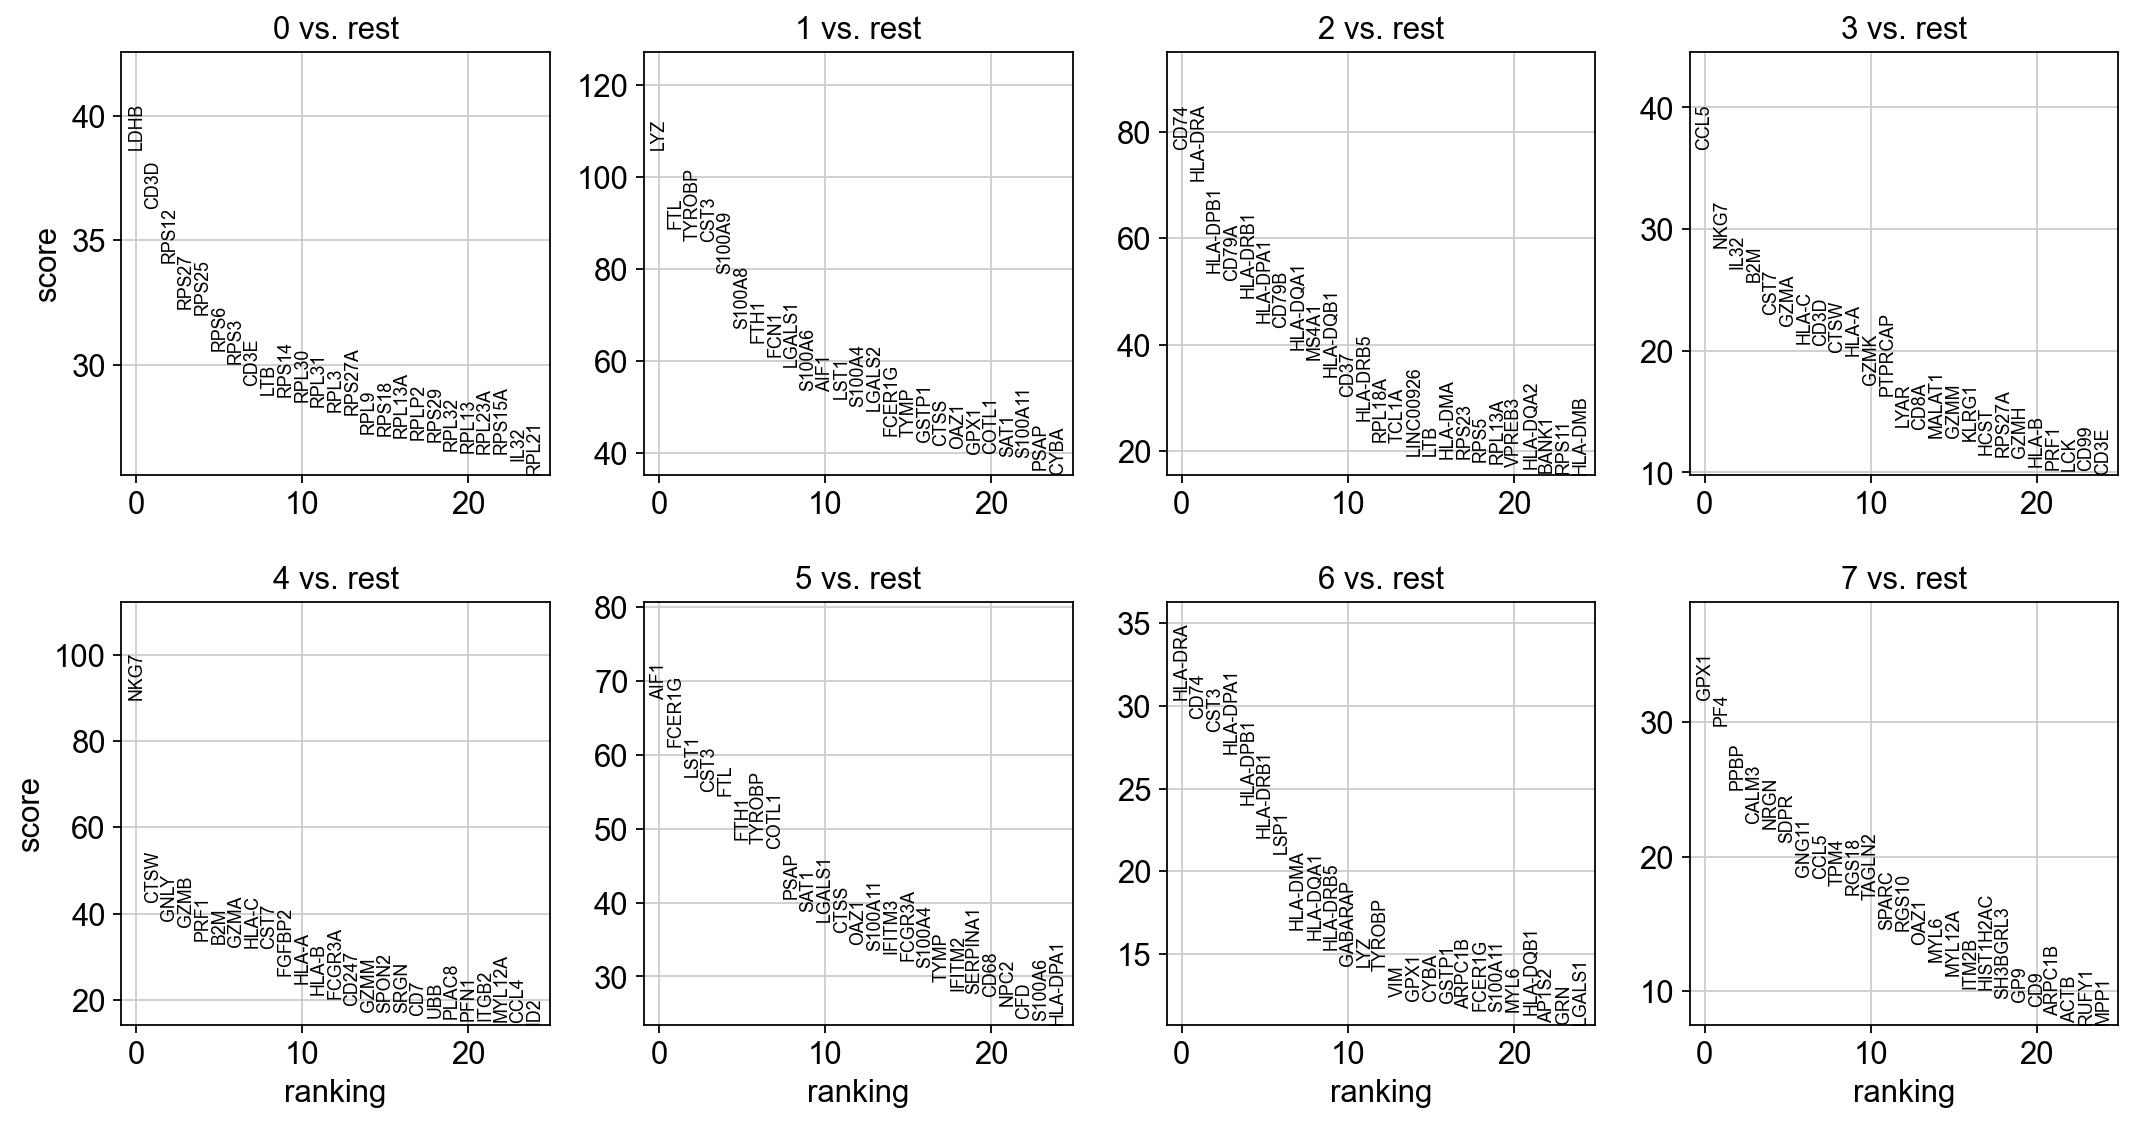

In [42]:
#problem here
sc.tl.rank_genes_groups(adata, 'leiden',method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [43]:
adata.uns['rank_genes_groups']['names']

rec.array([('LDHB', 'LYZ', 'CD74', 'CCL5', 'NKG7', 'AIF1', 'HLA-DRA', 'GPX1'),
           ('CD3D', 'FTL', 'HLA-DRA', 'NKG7', 'CTSW', 'FCER1G', 'CD74', 'PF4'),
           ('RPS12', 'TYROBP', 'HLA-DPB1', 'IL32', 'GNLY', 'LST1', 'CST3', 'PPBP'),
           ...,
           ('HLA-DPA1', 'LTB', 'IL32', 'FCER1G', 'AIF1', 'PTPRCAP', 'PRKCQ-AS1', 'EVL'),
           ('HLA-DRA', 'MALAT1', 'S100A4', 'LY86', 'LY86', 'IL32', 'GZMA', 'EIF3L'),
           ('HLA-DRB1', 'PTPRCAP', 'CD3D', 'S100A8', 'IFI30', 'CD3D', 'CD3G', 'ZFP36L2')],
          dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O')])

#### Wilcoxon Test (univariate)

In [44]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished (0:00:04)


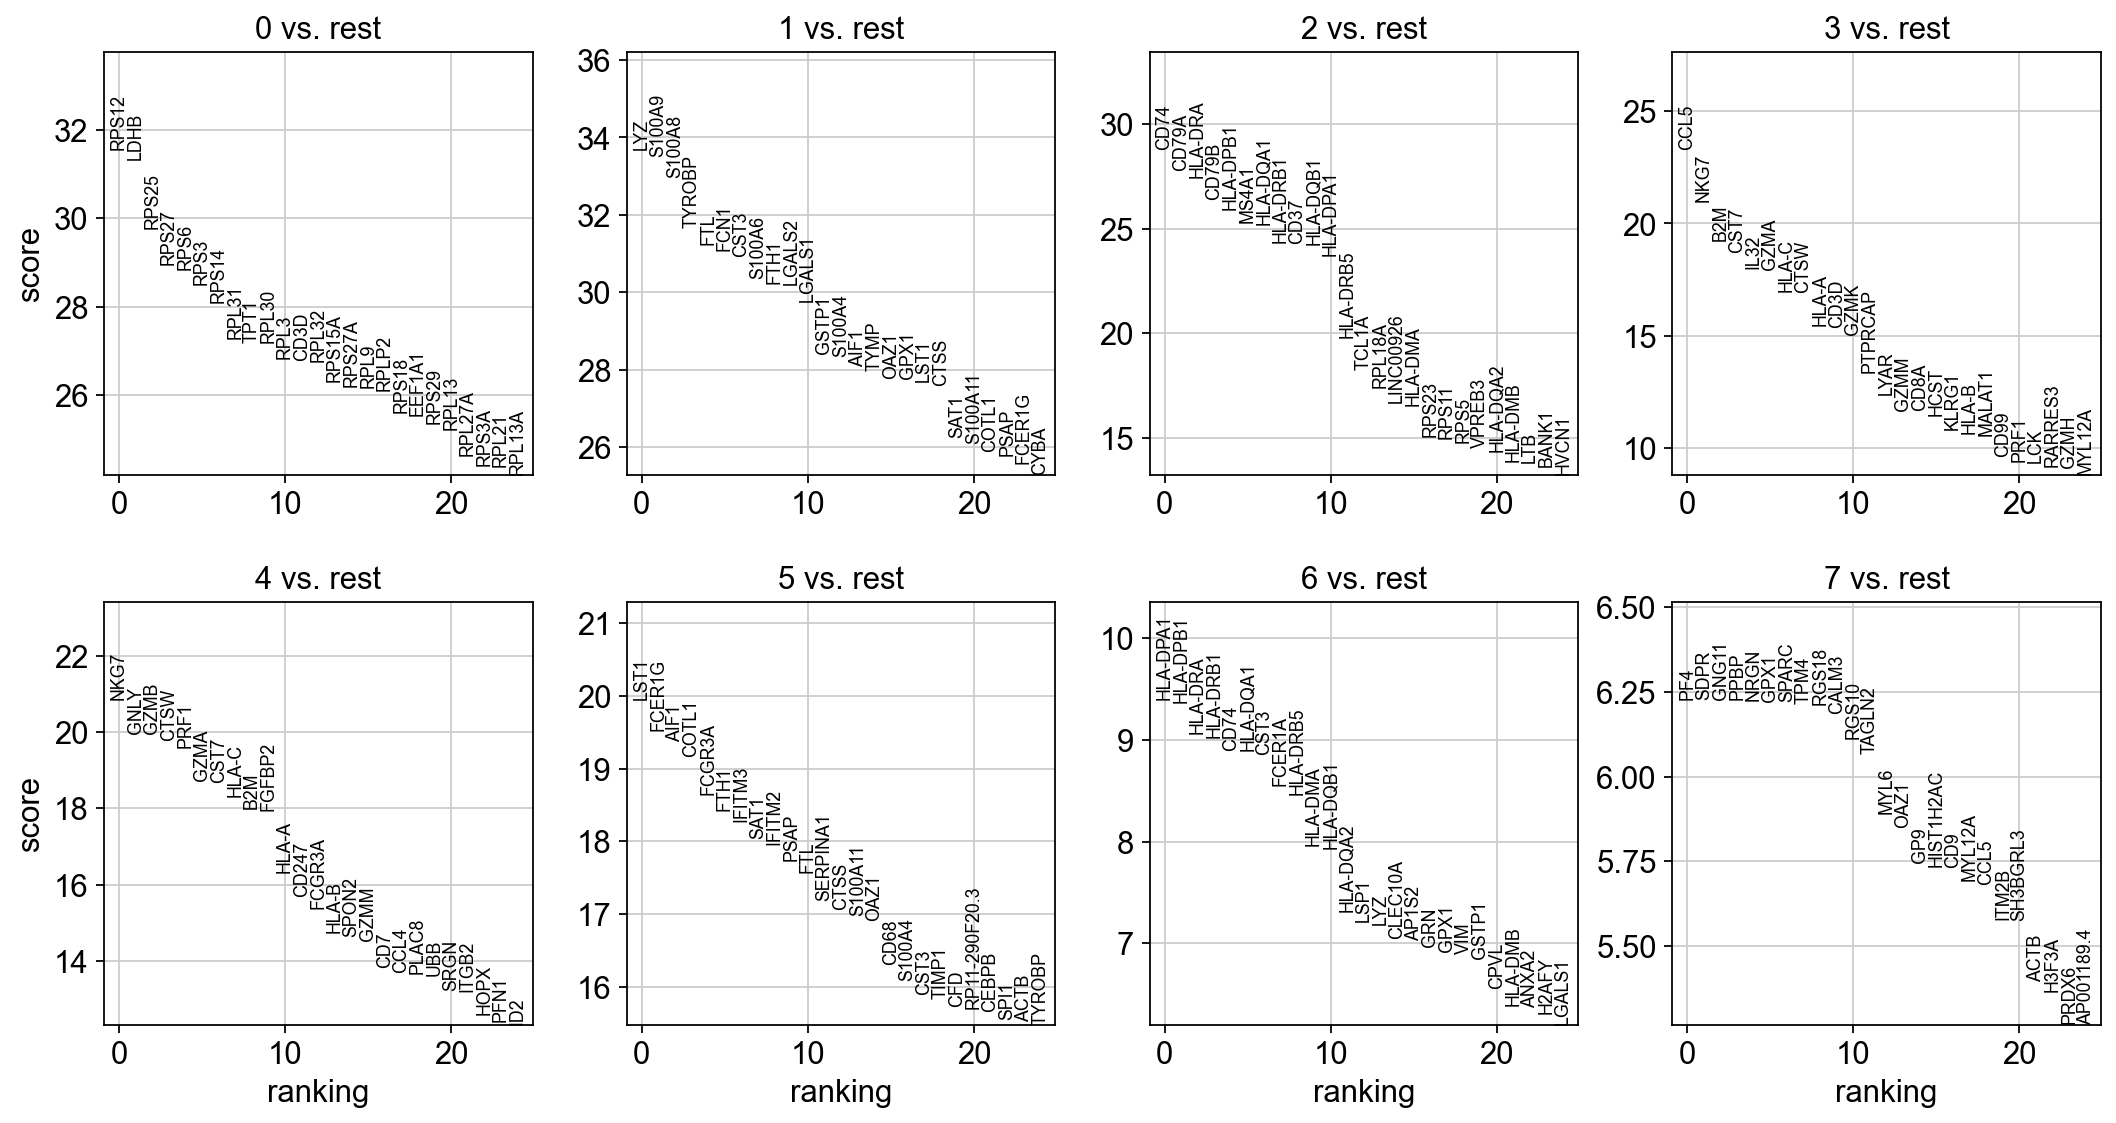

In [45]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

- wilcoxon test doesn't require the data fo two groups both follow normal distribution, on the contrary, t-test has the assumption that the data distribution of both groups follow normal distribution.
- 0 vs. rest: This subplot shows the top genes that characterize group 0 compared to all other groups. The x-axis represents the rank of the gene based on the test statistic, and the y-axis represents the score, which is likely a measure of the significance or strength of the differential expression (often a log-transformed p-value). Genes are listed in descending order of their score, so genes towards the top-left corner are the most differentially expressed in group 0 compared to other groups.

#### Logistic Regression (multi-variate)

ranking genes
    finished (0:00:06)


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


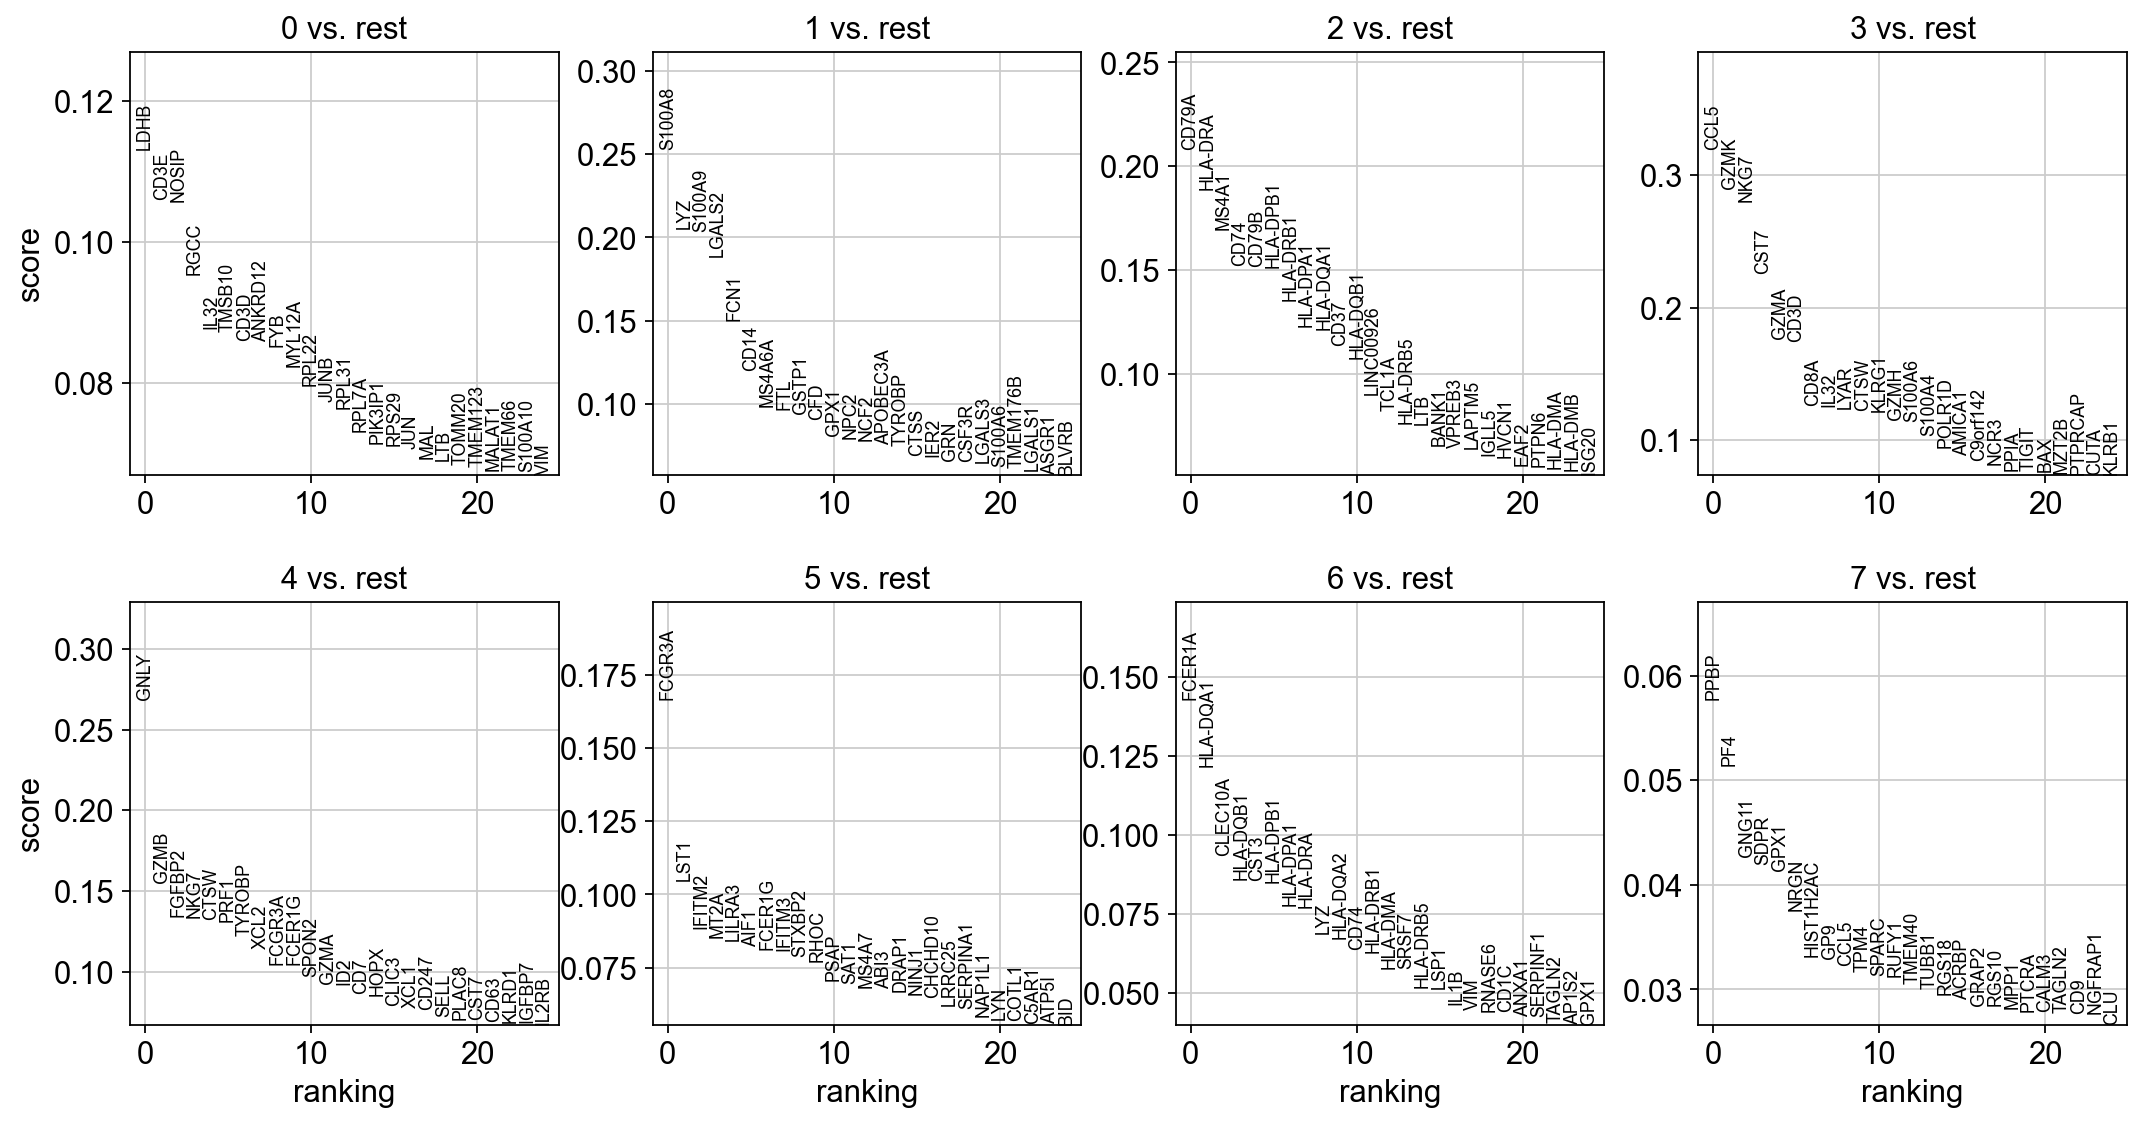

In [46]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [47]:
adata.var.shape

(1838, 13)

In [48]:
adata.write(results_file)

how to interpret the plot of logistic regression? what does the score mean on the y-axis: z-score

In [49]:
len(adata.uns['rank_genes_groups']['names'])

13714

In [50]:
adata.uns['rank_genes_groups']

{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 'logreg',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('LDHB', 'S100A8', 'CD79A', 'CCL5', 'GNLY', 'FCGR3A', 'FCER1A', 'PPBP'),
            ('CD3E', 'LYZ', 'HLA-DRA', 'GZMK', 'GZMB', 'LST1', 'HLA-DQA1', 'PF4'),
            ('NOSIP', 'S100A9', 'MS4A1', 'NKG7', 'FGFBP2', 'IFITM2', 'CLEC10A', 'GNG11'),
            ...,
            ('CCL5', 'HLA-DQA1', 'CD3D', 'TYROBP', 'VIM', 'LYZ', 'APOBEC3A', 'RPL29'),
            ('CST7', 'FCER1A', 'IL32', 'FCER1G', 'RPL36A', 'S100A8', 'FTL', 'RPS4Y1'),
            ('NKG7', 'FCGR3A', 'S100A4', 'GNLY', 'CD3D', 'LGALS2', 'CFD', 'RPS24')],
           dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O')]),
 'scores': rec.array([( 0.113185  ,  0.25300366,  0.20815372,  0.3195458 ,  0.26878232,  0.16660179,  0.14290449,  0.0577414 ),
            ( 0.10613731,  0.20560625,  0.18869722,  0.2903

In [51]:
adata.uns['rank_genes_groups']['names'] #what is the meaing of it? 

rec.array([('LDHB', 'S100A8', 'CD79A', 'CCL5', 'GNLY', 'FCGR3A', 'FCER1A', 'PPBP'),
           ('CD3E', 'LYZ', 'HLA-DRA', 'GZMK', 'GZMB', 'LST1', 'HLA-DQA1', 'PF4'),
           ('NOSIP', 'S100A9', 'MS4A1', 'NKG7', 'FGFBP2', 'IFITM2', 'CLEC10A', 'GNG11'),
           ...,
           ('CCL5', 'HLA-DQA1', 'CD3D', 'TYROBP', 'VIM', 'LYZ', 'APOBEC3A', 'RPL29'),
           ('CST7', 'FCER1A', 'IL32', 'FCER1G', 'RPL36A', 'S100A8', 'FTL', 'RPS4Y1'),
           ('NKG7', 'FCGR3A', 'S100A4', 'GNLY', 'CD3D', 'LGALS2', 'CFD', 'RPS24')],
          dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O')])

In [52]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [53]:
adata = sc.read(results_file)

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [54]:
rgp_names_df = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
print(rgp_names_df.head(5))
print(rgp_names_df.shape)

       0       1        2     3       4       5         6      7
0   LDHB  S100A8    CD79A  CCL5    GNLY  FCGR3A    FCER1A   PPBP
1   CD3E     LYZ  HLA-DRA  GZMK    GZMB    LST1  HLA-DQA1    PF4
2  NOSIP  S100A9    MS4A1  NKG7  FGFBP2  IFITM2   CLEC10A  GNG11
3   RGCC  LGALS2     CD74  CST7    NKG7    MT2A  HLA-DQB1   SDPR
4   IL32    FCN1    CD79B  GZMA    CTSW  LILRA3      CST3   GPX1
(13714, 8)


In [55]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
#pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals']}).head(5)

#### comnpare to a single cluster

ranking genes


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished (0:00:02)


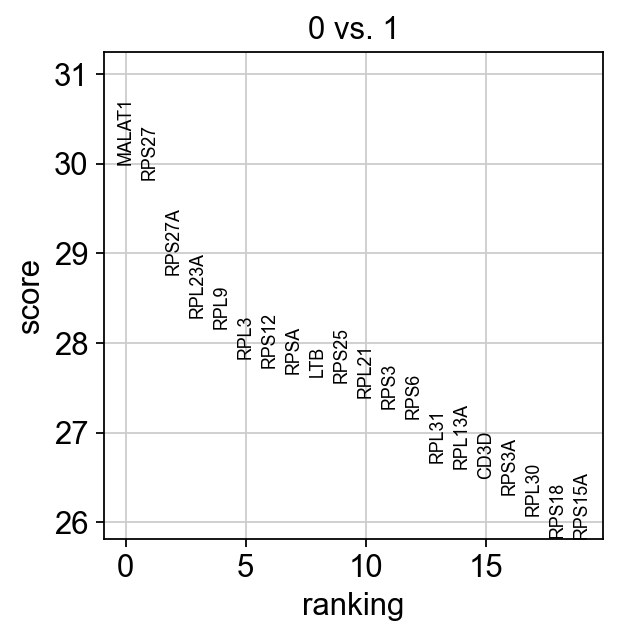

In [56]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


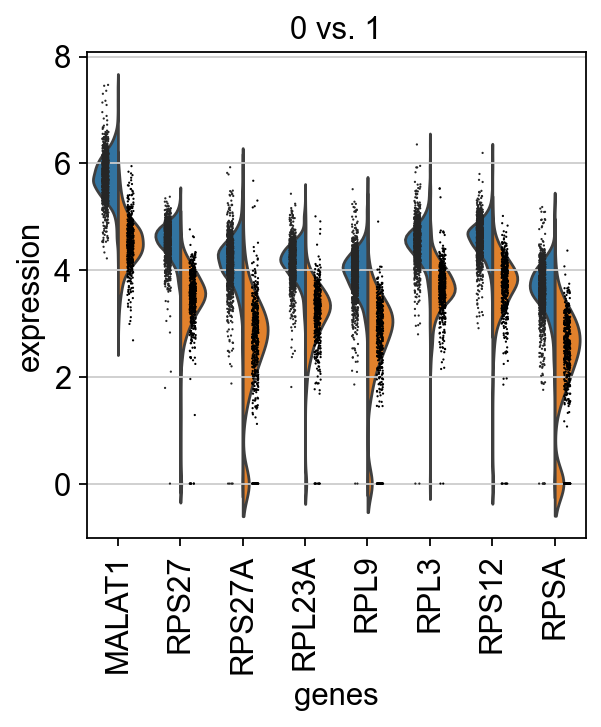

In [57]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_g

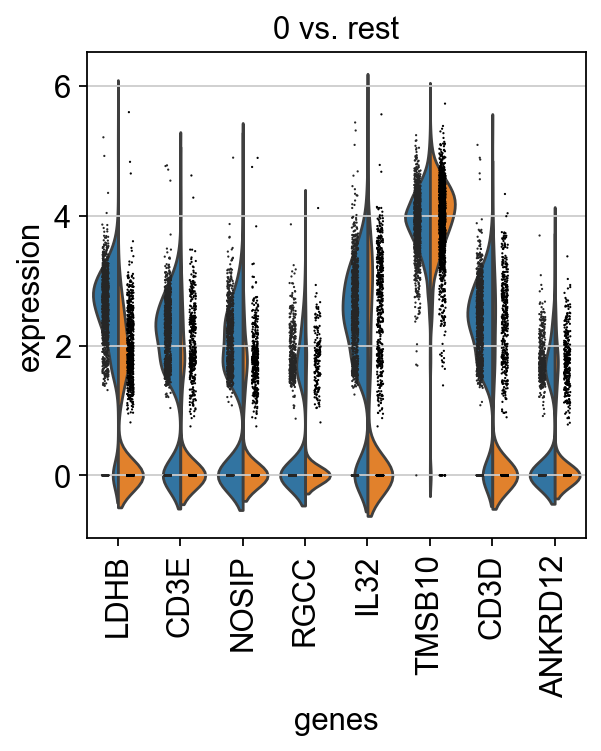

In [58]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be

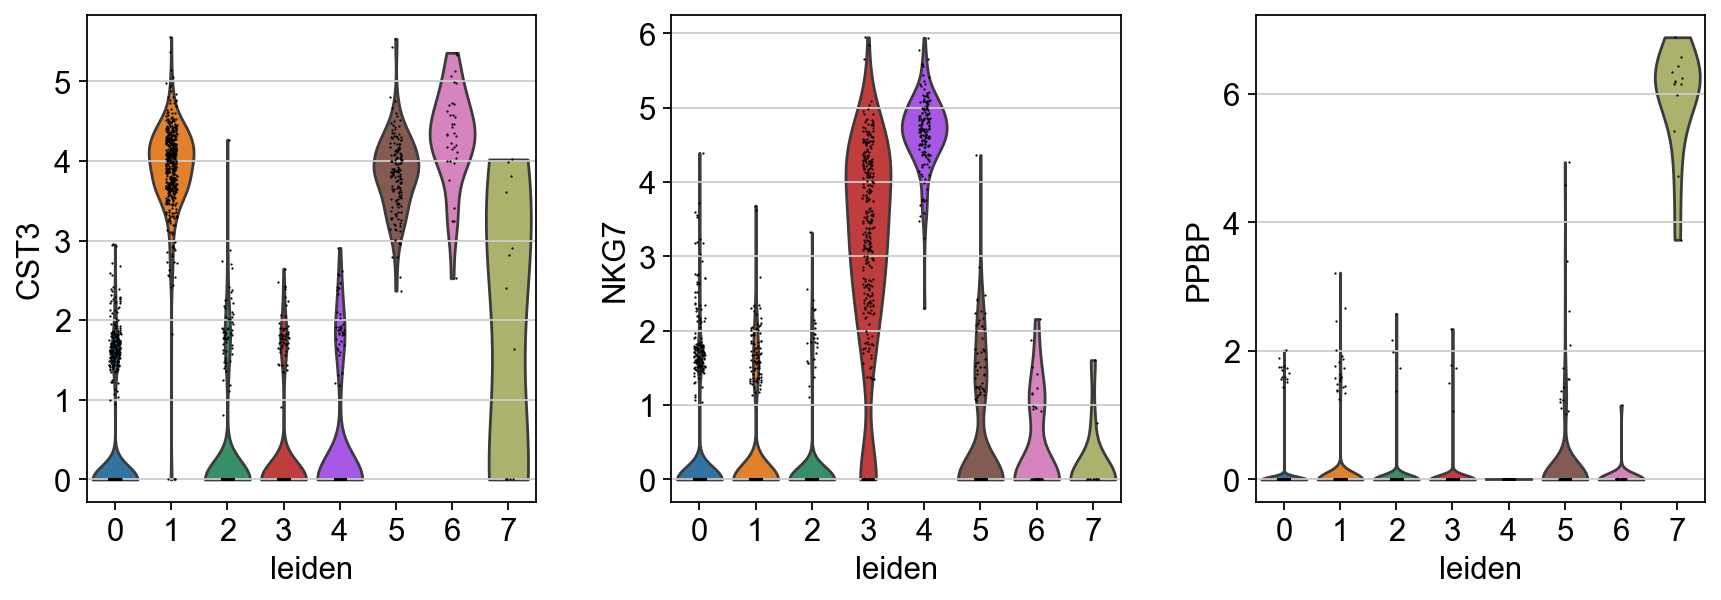

In [59]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Mark the cell types and replace the leiden cluster names with the cell-type names

In [60]:
new_cluster_names = ['CD4 T', 'CD14 Monocytes','B', 'CD8 T','NK', 'FCGR3A Monocytes','Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


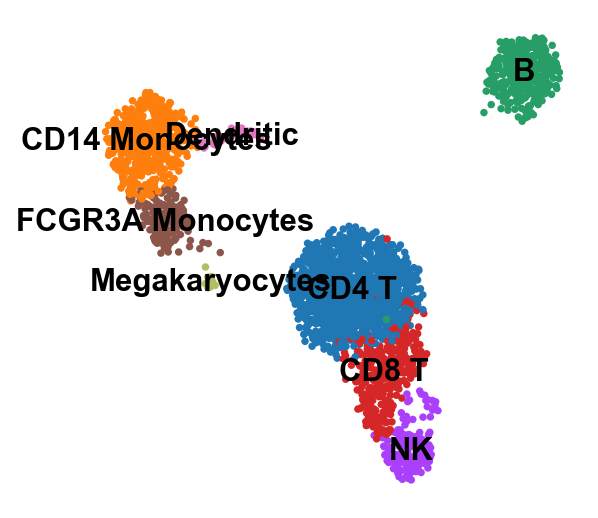

In [61]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

Visualzie the marker genes

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


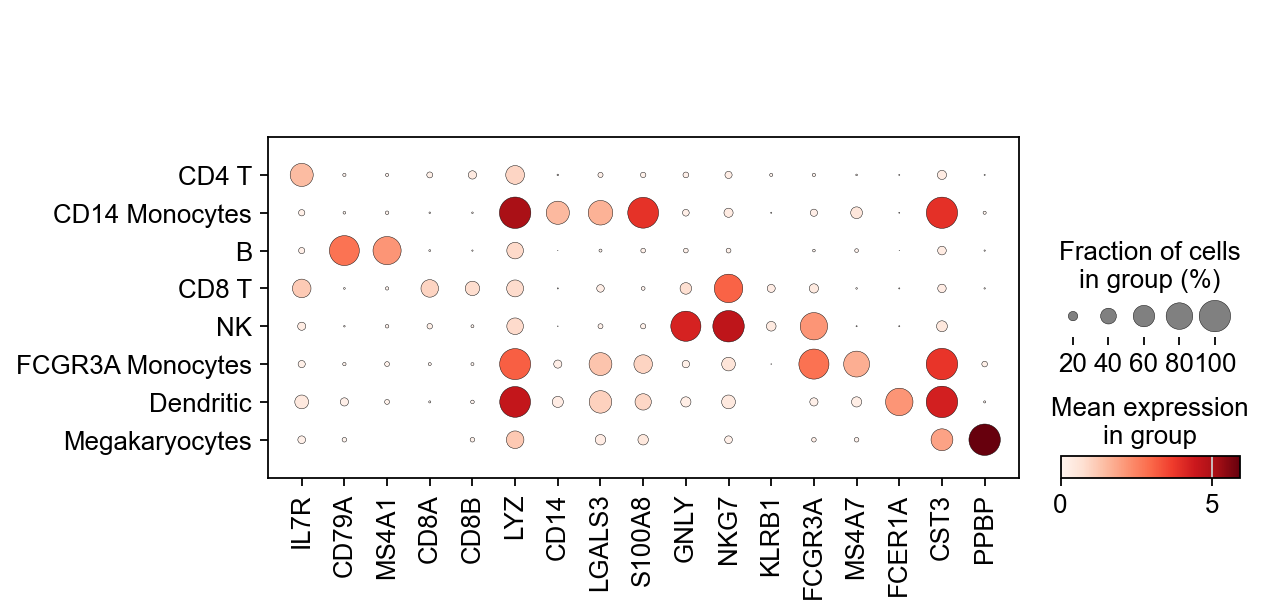

In [62]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_stacked_violin.py:324: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _color_df = _matrix.groupby(level=0).median()
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_stacked_violin.py:462: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_stacked_violin.py:462: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-pa

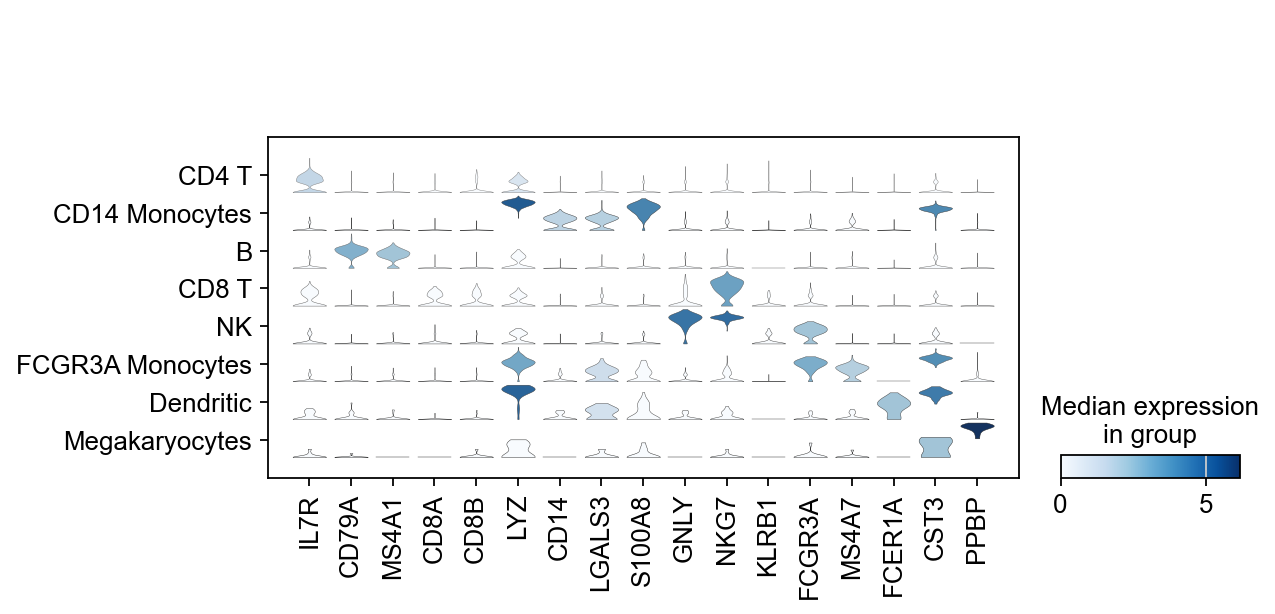

In [63]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden')

In [64]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'louvain', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [65]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

In [66]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')